Initial matrices and coefficients

In [0]:
import numpy as np

g = 9.8
m = 1
M = 4
l = 0.8
state = np.random.uniform(-1,1,4)

t = np.linspace(0,7,1000)

A = np.array([[0,             0, 1, 0],
              [0,             0, 0, 1],
              [0,         m*g/M, 0, 0],
              [0, (M+m)*g/(M*l), 0, 0]])

B = np.array([[0],[0], [1/M], [1/(M*l)]])

C = np.array([[1,0,0,0],[0,1,0,0]])

**Prove that it is possible to design state observer linearized system**\
Check the observability of the system

In [172]:
from numpy.linalg import matrix_rank

O = np.concatenate((C, C.dot(A), C.dot(A).dot(A), C.dot(A).dot(A).dot(A)), axis=0)

print(O)
print(matrix_rank(O))

[[ 1.      0.      0.      0.    ]
 [ 0.      1.      0.      0.    ]
 [ 0.      0.      1.      0.    ]
 [ 0.      0.      0.      1.    ]
 [ 0.      2.45    0.      0.    ]
 [ 0.     15.3125  0.      0.    ]
 [ 0.      0.      0.      2.45  ]
 [ 0.      0.      0.     15.3125]]
4


**For open loop state observer, is the error dynamics stable?**\
Real system:
<center>
$\dot{x} = Ax + Bu $
</center>
Imaginary system:
<center>
$\dot{s} = As + Bu $
</center>
Error dynamics:
<center>
$e = s - x $
</center>
<center>
$\dot{e} = A(s-x) = Ae$
</center>
As a result, we need to check the eigenvalues of A.

In [173]:
e, v = np.linalg.eig(A)
print("Eigenvalues of A:", e)

Eigenvalues of A: [ 0.          0.          3.91311896 -3.91311896]


**Design Luenberger observer for linearized system.**\
Real system:
<center>
$\dot{x} = Ax + Bu $
</center>
<center>
$y = Cx$
</center>
Imaginary system:
<center>
$\dot{s} = As + Bu + L(y-\hat{y})$
</center>
<center>
$\hat{y} = Cs$
</center>
Error:
<center>
$e = s - x $
</center>
<center>
$\dot{e} = As - Ax + L(Cx-Cs) = Ae - LCe = (A-LC)e$
</center>
<center>
$eig(A-LC) = eig(A^T - C^TL^T)$
</center>

**Using pole placement.**

In [174]:
from scipy.signal import place_poles

poles = np.array([-1,-2,-3,-4])

L = place_poles(A.transpose(), C.transpose(), poles).gain_matrix.transpose()

print(L)

[[ 5.      1.    ]
 [ 1.      5.    ]
 [ 5.5     4.95  ]
 [ 2.5    20.8125]]


**Using LQR.**

In [175]:
from scipy.linalg import solve_continuous_are as are

Q = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
Q = Q.dot(100)
R = np.array([[1,0],[0,1]])
S = are(A.transpose(), C.transpose(), Q, R)

L = C.dot(S).transpose()

print(L)

[[10.9719193   0.21374809]
 [ 0.21374809 12.92495096]
 [10.21435066  3.74210706]
 [ 1.36580322 33.5500228 ]]


**Design state feedback controller for linearized system.**

In [176]:
# Q = C.transpose().dot(C)
Q = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
Q = Q.dot(100)
R = np.array([[1]])
S = are(A, B, Q, R)

K = (B.transpose()).dot(S)

print(K)

[[-10.         189.41311337 -19.66106239  52.13000272]]


**Simulate nonlinear system with Luenberger observer and state feedback controller that uses estimated states (u = K$\hat{x}$)**

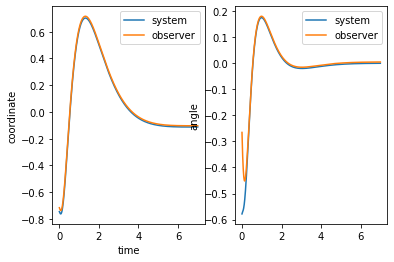

In [177]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt

A_new = np.concatenate((np.concatenate((A, np.zeros(A.shape)), axis=1), 
                        np.concatenate((np.zeros(A.shape), A), axis=1)),axis=0)

B_new = np.concatenate((B, B), axis = 0)

K_new = np.concatenate((np.zeros(K.shape), K), axis = 1)

state = np.random.uniform(-1, 1, 8)

v = 0.1
# print(v.shape)
# w = 1

def upd_ODE(x, time):
  u = -K_new.dot(x)
  x = x.reshape(8,1)
  temporary = L.dot(C).dot(x[0:4]-x[4:]) + v
  observer = np.concatenate((np.zeros((4,1)), temporary), axis = 0)
  return (A_new.dot(x)+ B_new.dot(u).reshape(8,1)+observer).reshape(8,)

solution = odeint(upd_ODE, state, t)

plt1 = plt.subplot(121)
plt2 = plt.subplot(122)

plt1.plot(t, solution[:,0], label='system')
plt1.plot(t, solution[:,4], label='observer')
plt1.set_xlabel("time")
plt1.set_ylabel("coordinate")

plt2.plot(t, solution[:,1], label='system')
plt2.plot(t, solution[:,5], label='observer')
plt1.set_xlabel("time")
plt2.set_ylabel("angle")
plt1.legend()
plt2.legend()
plt.show()

**Simulate nonlinear system with Luenberger observer and state feedback controller that uses estimated states (u = K$\hat{x}$) using discrete strategy.**

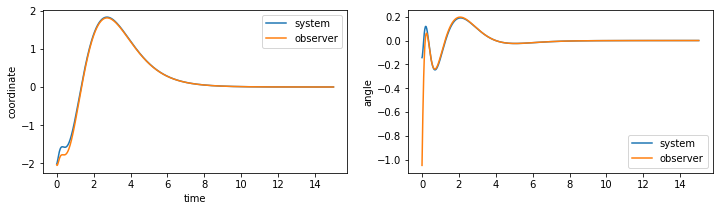

In [178]:
state = np.random.uniform(-3, 3, 8)

def system(z, t, u):
  # print((A.dot(z)+B.dot(u)).shape)
  return A.dot(z)+B.dot(u)

def luenberg(z,t,u,y):
  return (A.dot(z.reshape(4,1)) + B.dot(u).reshape(4,1) + L.dot(y-C.dot(z)).reshape(4,1)).transpose().flatten()

def discrete(z, time):
  x = z[:4]
  x1 = z[4:]
  plot = [x]
  plot1 = [x1]
  y = []
  y1 = []
  for i in range(len(time)-1):
    u = -K.dot(x1)
    result = odeint(system, x, [time[i], time[i+1]], args=(u,))
    plot.append(result[1])
    x = result[1]
    y.append(C.dot(x))
    result1 = odeint(luenberg, x1, [time[i], time[i+1]], args=(u,y[i]))
    plot1.append(result1[1])
    x1 = result1[1]
    y1.append(C.dot(x1))
  
  return np.array([np.array(plot), np.array(plot1)])

t = np.linspace(0,15,1000)
solution = discrete(state, t)

figure = plt.figure(figsize=(12,3))
plt1 = figure.add_subplot(121)
plt2 = figure.add_subplot(122)

plt1.plot(t, solution[0][:,0], label='system')
plt1.plot(t, solution[1][:,0], label='observer')
plt1.set_xlabel("time")
plt1.set_ylabel("coordinate")

plt2.plot(t, solution[0][:,1], label='system')
plt2.plot(t, solution[1][:,1], label='observer')
plt1.set_xlabel("time")
plt2.set_ylabel("angle")
plt1.legend()
plt2.legend()
plt.show()

**Add some white gaussian noise to the dynamics and output.**

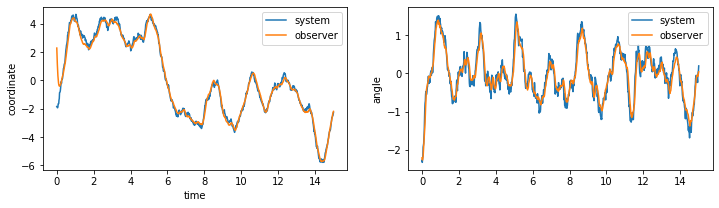

In [179]:
state = np.random.uniform(-3, 3, 8)

def system2(z, t, u):
  w = np.random.normal(0, 0.1, 4)
  # print((A.dot(z)+B.dot(u) + w).shape)
  return A.dot(z)+B.dot(u) + w

def luenberg2(z,t,u,y):
  return (A.dot(z.reshape(4,1)) + B.dot(u).reshape(4,1) + L.dot(y-C.dot(z)).reshape(4,1)).transpose().flatten()

def discrete2(z, time):
  x = z[:4]
  x1 = z[4:]
  plot = [x]
  plot1 = [x1]
  y = []
  y1 = []
  z = np.zeros((len(time), 4))
  z_hat = np.zeros((len(time), 4))
  z[0] = x
  z_hat[0] = x1
  for i in range(0, len(time) - 1):
    # Real system
    u = - K @ z_hat[i]
    w = np.random.normal(0, 0.1, 4)
    z_dot = (A @ z[i] + B @ u) 
    dt = time[i + 1] - time[i]
    z[i+1] = z[i] + z_dot * dt + w
    # Observer
    v = np.random.normal(0, 0.1, 2)
    y = C @ z[i] + v
    y_hat = C @ z_hat[i] 
    z_hat_dot = A @ z_hat[i] + B @ u + L @ (y - y_hat)
    z_hat[i+1] = z_hat[i] + z_hat_dot * dt
  
  return np.array([z,z_hat])

t = np.linspace(0,15,1000)
solution = discrete2(state, t)

figure = plt.figure(figsize=(12,3))
plt1 = figure.add_subplot(121)
plt2 = figure.add_subplot(122)

plt1.plot(t, solution[0][:,0], label='system')
plt1.plot(t, solution[1][:,0], label='observer')
plt1.set_xlabel("time")
plt1.set_ylabel("coordinate")

plt2.plot(t, solution[0][:,1], label='system')
plt2.plot(t, solution[1][:,1], label='observer')
plt1.set_xlabel("time")
plt2.set_ylabel("angle")
plt1.legend()
plt2.legend()
plt.show()